Imports

In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

#use seaborn for plotting defaults
import seaborn as sns; sns.set()

Data aquisition

In [2]:
def from_folder(folder_path):
    strokesets = []
    xml_paths = glob.glob(os.path.join(folder_path, "**/*.xml"), recursive=True)
    for xml_path in xml_paths:
        tree = ET.parse(xml_path)
        _strokesets = tree.find(".//StrokeSet")
        strokeSet = [np.array([(float(point.get("x")), float(point.get("y")), float(point.get("time")))
                               for point in stroke.findall("./Point")]) for stroke in _strokesets.findall("./Stroke")]
        strokesets.append(format_strokeset(strokeSet))
    return strokesets

def format_strokeset(strokeset):
    # compute bbox properties of strokeset
    pts = np.concatenate(strokeset, axis=0)  # extract the x,y coordinates
    pts = pts.reshape((-1, 3))[:, :2]
    x_min, y_min = np.min(pts, axis=0)
    x_max, y_max = np.max(pts, axis=0)
    w, h = x_max - x_min, y_max - y_min
    if w == 0 or h == 0:
        return None
    
    # transform the points in the strokeset so that the top-left of the bbox is their origin
    # starting time is set to 0 for that substract the first point time from all points time
    for stroke in strokeset:
        stroke -= [x_min, y_min, stroke[0, 2]]

    return strokeset

def display_strokeset(strokeset, scale_factor=0.1, title="Strokeset"):
    pts = np.concatenate(strokeset, axis=0)
    x_min, y_min = np.min(pts[:, :2], axis=0)
    x_max, y_max = np.max(pts[:, :2], axis=0)
    w, h = int(scale_factor * (x_max - x_min)), int(scale_factor * (y_max - y_min))
    if w == 0 or h == 0:
        return
    image = np.zeros((h, w), dtype=np.uint8)
    pts -= [x_min, y_min, 0]
    pts *= scale_factor
    pts = pts[:, :2]  # remove the z-dimension
    pts = pts.astype(np.int32)
    strokes = np.split(pts, np.cumsum([len(s) for s in strokeset[:-1]]))
    for stroke in strokes:
        cv2.polylines(image, [stroke], isClosed=False, color=255, thickness=2)
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
strokesets = from_folder("original")

In [4]:
# count the number of stroke in all the 0, 1, 2, 3 stroksets strokes with length less than 300 and greaterthan 2
stroke_count = [len(strokeset) for strokeset in strokesets[:4] if strokeset is not None and len(strokeset) < 300 and len(strokeset) > 2]
sum(stroke_count)

783

Preprocessing

In [5]:
# convert strokesets to a list of strokes efficiently
strokes = []   
for strokeset in strokesets:
    strokes.extend(strokeset)
len(strokes)

from collections import Counter

lengths = [len(stroke) for stroke in strokes]
freq_list = dict(Counter(lengths + [0]))


# save the sorted dictionary to txt file
with open('strokes_length.txt', 'w') as f:
    for key in sorted(freq_list.keys()):
        f.write("%s %s\n"%(key, freq_list[key]))

#remove every stroke with length greater than 300 and less than 2
strokes = [stroke for stroke in strokes if len(stroke) <= 300 and len(stroke) > 2]

# replace every stroke with length less than 300 with a stroke of length 300
max_length = 300
strokes = np.array([np.concatenate([stroke, np.zeros((max_length - len(stroke), 3))]) for stroke in strokes])


In [6]:
strokes.shape

(267141, 300, 3)

Auto-encoder for correcting anomalies

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import time
import random


In [8]:
strokes = torch.from_numpy(strokes).float()

MAX_STROKE_LEN = 300

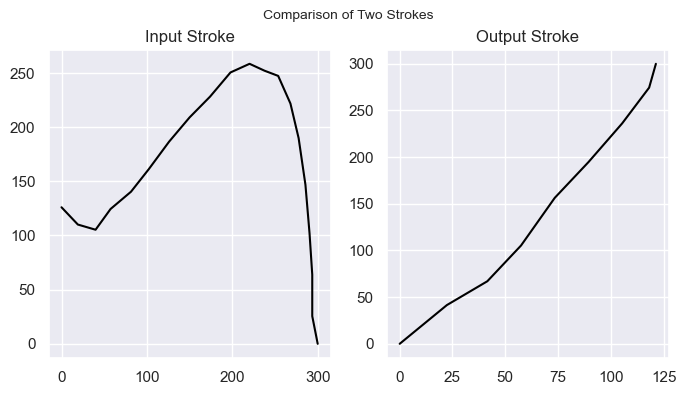

In [9]:
def display_strokes(stroke1, stroke2):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

    def process_stroke(stroke):
        stroke = stroke.numpy()
        stroke = stroke[~(np.all(stroke == 0, axis=1))]
        x_min, y_min = np.min(stroke[:, :2], axis=0)
        x_max, y_max = np.max(stroke[:, :2], axis=0)
        scale_factor = 300 / max(x_max - x_min, y_max - y_min)
        stroke -= [x_min, y_min, stroke[0, 2]]
        stroke *= scale_factor
        stroke = stroke[:, :2]
        return stroke

    # Stroke 1
    stroke1 = process_stroke(stroke1)
    ax1.plot(stroke1[:, 0], stroke1[:, 1], color='black')
    ax1.set_title("Input Stroke")

    # Stroke 2
    stroke2 = process_stroke(stroke2)
    ax2.plot(stroke2[:, 0], stroke2[:, 1], color='black')
    ax2.set_title("Output Stroke")

    # Set plot title
    fig.suptitle("Comparison of Two Strokes", fontsize=10)

    plt.show()

display_strokes(strokes[723], strokes[724])

In [10]:
# Dataset

class StrokeDataset(Dataset):
    def __init__(self, strokes):
        self.strokes = strokes

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, index):
        stroke = self.strokes[index]
        return stroke, stroke

In [24]:
# Auto-encoder

# LSTM() returns tuple of (tensor, (recurrent state))
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]
    
class NormalizeStrokes(nn.Module):
    def __init__(self):
        super(NormalizeStrokes, self).__init__()

    def forward(self, strokes):
        # Orient all the strokes to start from the origin
        strokes = strokes - strokes[:,0:1,:]

        # Rescale the strokes to have unit norm
        means = torch.mean(strokes, axis=(0, 1), keepdim=True)
        stds = torch.std(strokes, axis=(0, 1), keepdim=True)
        normalized_strokes = (strokes - means) / stds
        return normalized_strokes
    
# Custom Loss class that normalises the input and compued the MSE loss
class StrokeLoss(nn.Module):
    def __init__(self):
        super(StrokeLoss, self).__init__()
        self.normalize = NormalizeStrokes()

    def forward(self, output, target):
        # Normalize the inputs
        target = self.normalize(target)
        
        # Compute the MSE loss
        mse_loss = nn.MSELoss()(output, target)
        return mse_loss



class StrokeAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(StrokeAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            NormalizeStrokes(),
            nn.LSTM(input_dim, hidden_dim, batch_first=True),
            extract_tensor(),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.LSTM(latent_dim, hidden_dim, batch_first=True),
            extract_tensor(),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * MAX_STROKE_LEN),
        )

    def forward(self, x):
        # Encode the input sequence
        latent = self.encoder(x)

        # Reshape the hidden state for the decoder
        z = latent.view(-1, 1, self.latent_dim)

        # Decode the encoded sequence
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, MAX_STROKE_LEN, self.input_dim)

        return x_hat


In [27]:
# Model and dataset properties

model = StrokeAutoencoder(input_dim=3, hidden_dim=128, latent_dim=64)

dataset = StrokeDataset(strokes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create a dataset that contains a subset of the data
disp_indices = list(range(700, 797))
disp_dataset = torch.utils.data.Subset(dataset, disp_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

criterion = StrokeLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Batch 1/13357: 6.1795 seconds	 Loss: 1.0014
Batch 2/13357: 5.9511 seconds	 Loss: 0.9876
Batch 3/13357: 6.8185 seconds	 Loss: 0.9644
Batch 4/13357: 0.9023 seconds	 Loss: 0.9063
Batch 5/13357: 0.8826 seconds	 Loss: 1.0176
Batch 6/13357: 0.8911 seconds	 Loss: 0.9293
Batch 7/13357: 0.8659 seconds	 Loss: 0.8255
Batch 8/13357: 0.8691 seconds	 Loss: 0.8785
Batch 9/13357: 0.8889 seconds	 Loss: 0.9458
Batch 10/13357: 0.8760 seconds	 Loss: 0.9363


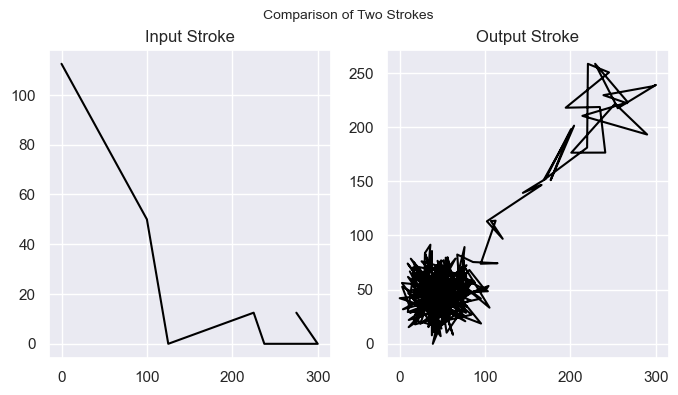

Epoch 1/10, Batch 10/13357: train_loss=0.9393
Batch 11/13357: 0.8756 seconds	 Loss: 0.9245
Batch 12/13357: 1.0594 seconds	 Loss: 0.8804
Batch 13/13357: 0.9757 seconds	 Loss: 0.8845
Batch 14/13357: 0.9075 seconds	 Loss: 0.8614
Batch 15/13357: 0.8439 seconds	 Loss: 0.9952
Batch 16/13357: 0.8569 seconds	 Loss: 0.9061
Batch 17/13357: 0.8578 seconds	 Loss: 0.9036
Batch 18/13357: 0.8711 seconds	 Loss: 0.8874
Batch 19/13357: 0.8648 seconds	 Loss: 0.9313
Batch 20/13357: 0.8662 seconds	 Loss: 0.8140


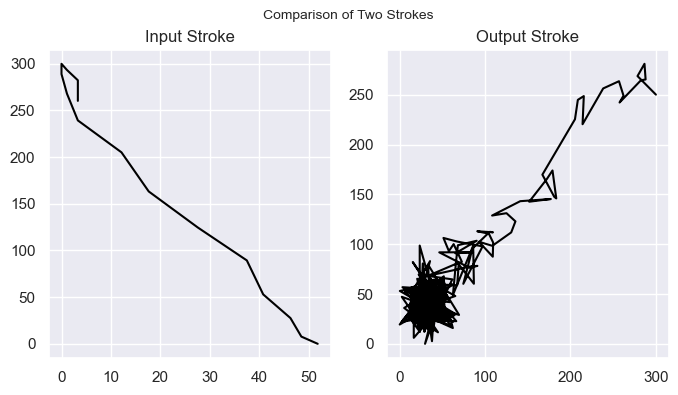

Epoch 1/10, Batch 20/13357: train_loss=0.8988
Batch 21/13357: 0.8599 seconds	 Loss: 0.7762
Batch 22/13357: 0.8590 seconds	 Loss: 0.7272
Batch 23/13357: 0.8575 seconds	 Loss: 0.7242
Batch 24/13357: 0.8522 seconds	 Loss: 0.7512
Batch 25/13357: 0.8489 seconds	 Loss: 0.6560
Batch 26/13357: 0.8668 seconds	 Loss: 0.8507
Batch 27/13357: 0.8595 seconds	 Loss: 0.8065
Batch 28/13357: 0.8516 seconds	 Loss: 0.7918
Batch 29/13357: 0.8482 seconds	 Loss: 0.7278
Batch 30/13357: 0.8427 seconds	 Loss: 0.7565


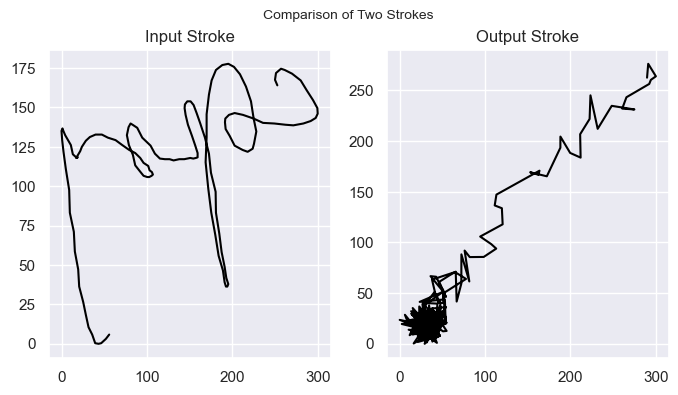

Epoch 1/10, Batch 30/13357: train_loss=0.7568
Batch 31/13357: 1.0512 seconds	 Loss: 0.8461
Batch 32/13357: 1.0916 seconds	 Loss: 0.8332
Batch 33/13357: 1.1095 seconds	 Loss: 0.9243
Batch 34/13357: 1.1073 seconds	 Loss: 0.7282
Batch 35/13357: 1.0470 seconds	 Loss: 0.6925
Batch 36/13357: 0.8795 seconds	 Loss: 0.7592
Batch 37/13357: 0.8749 seconds	 Loss: 0.7762
Batch 38/13357: 1.2312 seconds	 Loss: 0.8621
Batch 39/13357: 0.9213 seconds	 Loss: 0.8471
Batch 40/13357: 0.9076 seconds	 Loss: 0.6611


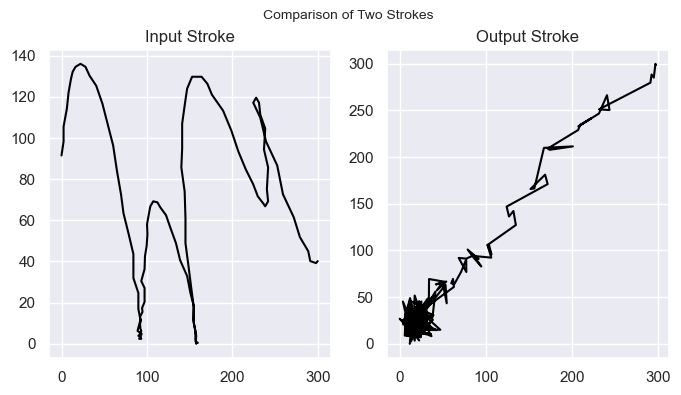

Epoch 1/10, Batch 40/13357: train_loss=0.7930
Batch 41/13357: 0.9571 seconds	 Loss: 0.8451
Batch 42/13357: 1.0754 seconds	 Loss: 0.8013
Batch 43/13357: 1.0495 seconds	 Loss: 0.7592
Batch 44/13357: 0.8852 seconds	 Loss: 0.7528
Batch 45/13357: 1.0555 seconds	 Loss: 0.7588
Batch 46/13357: 1.0113 seconds	 Loss: 0.6561
Batch 47/13357: 0.8774 seconds	 Loss: 0.7344
Batch 48/13357: 0.8910 seconds	 Loss: 0.7400
Batch 49/13357: 1.0696 seconds	 Loss: 0.6303
Batch 50/13357: 1.1059 seconds	 Loss: 0.7310


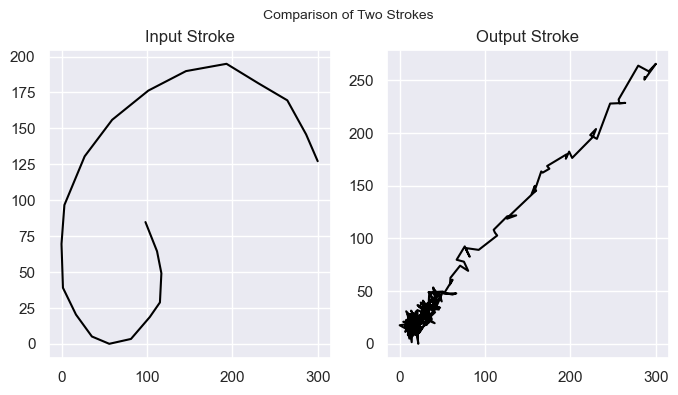

Epoch 1/10, Batch 50/13357: train_loss=0.7409
Batch 51/13357: 1.0006 seconds	 Loss: 0.6604
Batch 52/13357: 1.1177 seconds	 Loss: 0.6018
Batch 53/13357: 0.9415 seconds	 Loss: 0.6073
Batch 54/13357: 0.9263 seconds	 Loss: 0.4887
Batch 55/13357: 0.9243 seconds	 Loss: 0.5303
Batch 56/13357: 0.9701 seconds	 Loss: 0.4901
Batch 57/13357: 1.0486 seconds	 Loss: 0.6312
Batch 58/13357: 1.1261 seconds	 Loss: 0.4307
Batch 59/13357: 0.9654 seconds	 Loss: 0.4930
Batch 60/13357: 0.9433 seconds	 Loss: 0.7701


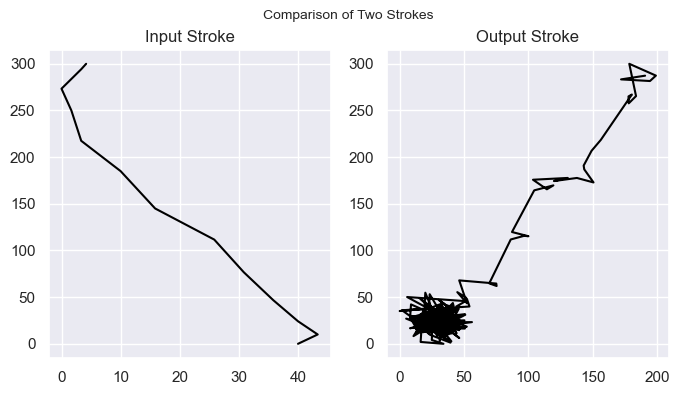

Epoch 1/10, Batch 60/13357: train_loss=0.5704
Batch 61/13357: 0.9177 seconds	 Loss: 0.6247
Batch 62/13357: 1.0171 seconds	 Loss: 0.4322
Batch 63/13357: 0.9574 seconds	 Loss: 0.5969
Batch 64/13357: 0.9601 seconds	 Loss: 0.5342
Batch 65/13357: 0.9262 seconds	 Loss: 0.5907
Batch 66/13357: 0.9228 seconds	 Loss: 0.5161
Batch 67/13357: 0.9849 seconds	 Loss: 0.4746
Batch 68/13357: 0.9579 seconds	 Loss: 0.5763
Batch 69/13357: 0.9415 seconds	 Loss: 0.3679
Batch 70/13357: 0.9301 seconds	 Loss: 0.3685


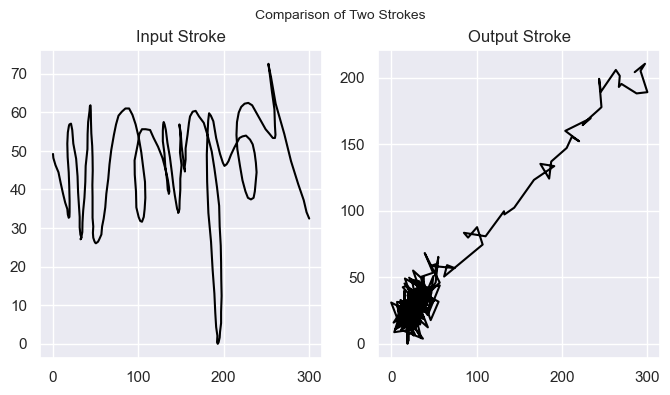

Epoch 1/10, Batch 70/13357: train_loss=0.5082
Batch 71/13357: 0.8835 seconds	 Loss: 0.4713
Batch 72/13357: 0.9430 seconds	 Loss: 0.4608
Batch 73/13357: 0.9363 seconds	 Loss: 0.4464
Batch 74/13357: 0.9156 seconds	 Loss: 0.3760
Batch 75/13357: 0.8831 seconds	 Loss: 0.4926
Batch 76/13357: 0.9346 seconds	 Loss: 0.5172
Batch 77/13357: 0.9250 seconds	 Loss: 0.3996
Batch 78/13357: 0.9509 seconds	 Loss: 0.5265
Batch 79/13357: 1.0673 seconds	 Loss: 0.4712
Batch 80/13357: 0.9486 seconds	 Loss: 0.4301


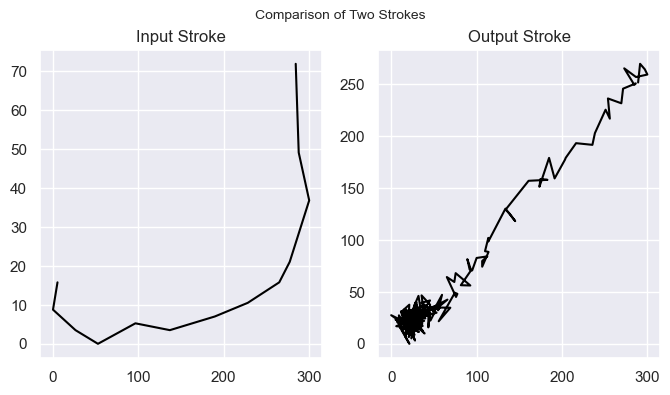

Epoch 1/10, Batch 80/13357: train_loss=0.4592
Batch 81/13357: 1.0695 seconds	 Loss: 0.3697
Batch 82/13357: 0.9900 seconds	 Loss: 0.5038
Batch 83/13357: 1.0716 seconds	 Loss: 0.4210
Batch 84/13357: 1.0458 seconds	 Loss: 0.3801
Batch 85/13357: 1.2127 seconds	 Loss: 0.4156
Batch 86/13357: 1.0731 seconds	 Loss: 0.3545
Batch 87/13357: 0.9655 seconds	 Loss: 0.3572
Batch 88/13357: 0.9429 seconds	 Loss: 0.3615
Batch 89/13357: 0.9340 seconds	 Loss: 0.5523


In [28]:
# Training loop

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    # Training loop
    for i, batch in enumerate(train_loader):

        #start timer
        start = time.time()

        optimizer.zero_grad()
        input_seq, target_seq = batch
        output_seq = model(input_seq)
        loss = criterion(output_seq, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # print time elapsed after evry batch in format
        end = time.time()
        print(f"Batch {i+1}/{len(train_loader)}: {end - start:.4f} seconds\t Loss: {loss.item():.4f}")

        print_every = 10
        if (i+1) % print_every == 0:
            
            # Select a random element from the dataset
            random_element = random.choice(disp_dataset)

            input_seq, target_seq = random_element
            input_seq = input_seq.unsqueeze(0)

            # Generate the output sequence using the model
            output_seq = model(input_seq)

            # Display the input and output strokes for the first sequence in the batch
            display_strokes(input_seq[0], output_seq[0].detach())


            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}: train_loss={train_loss/print_every:.4f}")
            train_loss = 0.0

    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            input_seq, target_seq = batch
            output_seq = model(input_seq)
            val_loss += criterion(output_seq, target_seq).item() * input_seq.size(0)
        val_loss /= len(val_dataset)

    # Print the training and validation losses for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss/len(train_loader):.4f} val_loss={val_loss:.4f}")